In [1]:
#%matplotlib inline # comment out for Jupyter, leave in for Jupyterlab widgets

import obspy
from obspy.io.segy.core import _read_segy
import numpy as np
import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib  import gridspec
import matplotlib.cm as cm
import scipy.signal as sig
from scipy.signal import butter, lfilter, freqz
from scipy.signal import sosfilt, sosfiltfilt, sosfreqz
from scipy.signal import minimum_phase, welch, medfilt
from scipy.linalg import solve_toeplitz
from numpy.fft import fft, ifft, ifftshift


## load segy data

data loaded into 2D array, headers into separate 1D arrays, see obspy docs

see github.com/obspy/obspy/blob/master/obspy/io/segy/header.py#L53

In [2]:
def readsegy(inputfile, file_headers,DF_ASL, SrcElev, SRD_ASL, PTS):
    
    """ Load a segy file using obspy read_segy routine
        Number of traces can come from binary header or trace headers or
        the shape of the data file
        
        nrcv = section.stats.binary_file_header.number_of_data_traces_per_ens.
        can be useful if filled
        
        We use the matrix shape in this example to figure out the number of 
        traces and the number of samples per trace
        
        inputfile - segy file
        file_headers  - optionally print binary headers to terminal
        DF_ASL - drill floor elevation above Sea Level
        SrcElev - source elevation above sea level
        SRD_ASL - seismic reference datum above sea level
        
        Some useful headers are filled for velocity calculation
    """
    
    from obspy.io.segy.segy import _read_segy
    
    section = _read_segy(inputfile, unpack_headers = 'True')
    
    if (file_headers == 'y') or (file_headers == 'Y'):
    
        print (section.binary_file_header)
    
        x = np.array(list(section.textual_file_header.decode()))
        
        print('\n'.join(''.join(row) for row in x.reshape((40, 80))))
            
    data = np.vstack([d.data for d in section.traces])
    
    nrcv, samples = data.shape
  
    print("\u0332".join('\nData Loading Stats :'))
    
    print (' data shape :', data.shape)
    
    print (' samples :', data.shape[1],' traces :', data.shape[0])
    
    ####### get basic info from trace headers and save in 1d arrays #########      
    
    trnum, ffid, geo, nsamp, srate, zscale = (np.empty((nrcv,1)),np.empty((nrcv,1)),
                                        np.empty((nrcv,1)),np.empty((nrcv,1)), 
                                        np.empty((nrcv,1)), np.empty((nrcv,1)))

    zrcv, tsr, mdpth, tvddpth = (np.empty((nrcv,1)),np.empty((nrcv,1)),
                                        np.empty((nrcv,1)),np.empty((nrcv,1)))

    scalcoord, xsrc, ysrc, sdpth = (np.empty((nrcv,1)),np.empty((nrcv,1)),
                                        np.empty((nrcv,1)),np.empty((nrcv,1))) 

    xrcv, yrcv, auxtime_ms, ttime = (np.empty((nrcv,1)),np.empty((nrcv,1)),
                                        np.empty((nrcv,1)),np.empty((nrcv,1)))

    ttime_ms,iline = (np.empty((nrcv,1)),np.empty((nrcv,1)))

    n=0

    for tr in section.traces:
    
        trnum[n] = tr.header.trace_sequence_number_within_line
        ffid[n] = tr.header.original_field_record_number
        geo[n] = tr.header.energy_source_point_number
        nsamp[n] = tr.header.number_of_samples_in_this_trace
        srate[n] = tr.header.sample_interval_in_ms_for_this_trace
        zscale[n] = tr.header.scalar_to_be_applied_to_all_elevations_and_depths
        mdpth[n] = tr.header.distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group
        tvddpth[n] = tr.header.receiver_group_elevation
        scalcoord[n] = tr.header.scalar_to_be_applied_to_all_coordinates
        xsrc[n] = tr.header.source_coordinate_x/abs(scalcoord[n])
        ysrc[n] = tr.header.source_coordinate_y/abs(scalcoord[n])
        sdpth[n] = tr.header.source_depth_below_surface
        xrcv[n] = tr.header.group_coordinate_x/abs(scalcoord[n])
        yrcv[n] = tr.header.group_coordinate_y/abs(scalcoord[n])
        auxtime_ms[n]  = tr.header.lag_time_A          #trunc. to nearest ms
        ttime_ms[n]  = tr.header.lag_time_B            # trunc.to nearest ms
        ttime[n]  = tr.header.shotpoint_number/100     # divide if used
        iline[n] = tr.header.for_3d_poststack_data_this_field_is_for_in_line_number
        n=n+1
    
    mdpth = mdpth/abs(zscale)
    
    tvddpth = tvddpth/abs(zscale)
    
    ############## shift elevations to reference datum ######################
    
    SrcZ = (sdpth *0) + SrcElev # careful, comment out if field is correct

    TVD_Src = tvddpth - (DF_ASL - SrcElev)
        
    TVD_SRD = tvddpth - (DF_ASL - SRD_ASL)
    
    SrcZ_SRD = SrcZ-SRD_ASL
    
    ############## make a file of trace headers #############################
    
    thead = np.hstack((trnum, mdpth, tvddpth,xrcv, yrcv,  xsrc, ysrc, sdpth, 
                       ttime,TVD_SRD, TVD_Src, SrcZ_SRD,auxtime_ms, iline, geo,
                      ffid))
    
    print (' trace header file shape :', thead.shape)
        
    ############## sort out sample rates ####################################
    
    numsamp = nsamp[0]
    samprate = srate[0]                    # sample interval in microseconds
    samprate_hz = 1000000/samprate
    
    print (' ttime: ',ttime.shape, ' fs samprate hz : ', samprate_hz, \
           'samprate microseconds : ', samprate, \
           '\n numsamp from headers : ', numsamp)
    
    print (' first time header value : ',ttime[0:1], \
           '\n first auxilliary time header value :', auxtime_ms[0:1])
    
    print (' source depth from header trace 1 :', sdpth[0:1])
    
    if (PTS == 'y') or (PTS == 'Y'):
        
        from tabulate import tabulate
        
        thead_tabl = np.hstack((mdpth, tvddpth,xrcv, yrcv,  xsrc, ysrc, sdpth, 
                       ttime,TVD_SRD, TVD_Src, SrcZ_SRD, geo, ffid))
    
        headers = [ "Meas Depth", "Depth SRD","Rec X", "Rec Y",
                   "Src X", "Src Y","Src Z", "Obs Time","TVD Depth", "TVD SrcZ",
                   "SrcZ SRD", " Geophone", "FFID"]
    
        table = tabulate(thead_tabl, headers, tablefmt="pretty")

        print(table)

    return data, numsamp, samprate, samprate_hz, thead

## Write a data stream to a segy file

using obspy segy writer, works but still looking for better way

In [3]:
def write_segy(data, tracehead,fs, name):
    
    print("\u0332".join('\nWrite Segy Stats :'))
    
    print ('Data shape [0] :', data.shape[0],'Data shape [1] :', data.shape[1])
    
    print('Trace header shape', tracehead.shape)
    
    print ('time header :', tracehead[0:2,:])
    
    from obspy.core import read, Trace, AttribDict, Stream, UTCDateTime
    from obspy.io.segy.segy import SEGYBinaryFileHeader

    from obspy.io.segy.segy import SEGYTraceHeader
    from obspy.io.segy.segy import SEGYFile
    
    MD = tracehead[:,1].astype(int)
#    print ('MD shape :', MD.shape, ' MD dtype :' , MD.dtype)
    TVD = tracehead[:,2].astype(int)
    TVD = TVD.reshape(-1)
    RcvX = tracehead[:,3].astype(int)
    RcvY = tracehead[:,4].astype(int)
    SrcX = tracehead[:,5].astype(int)
    SrcY = tracehead[:,6].astype(int)
    SrcZ = tracehead[:,7].astype(int)
    TVD_SRD = tracehead[:,9].astype(int)
    TVD_Src = tracehead[:,10].astype(int)
    SrcZ_SRD = tracehead[:,11].astype(int)
    Tobs = (tracehead[:,8]*100).astype(int)
    IntV = tracehead[:,13].astype(int)
    
    print ('MD shape :', MD.shape, ' MD dtype :' , MD.dtype)
    
    stream = obspy.Stream()
    
    scalcoord = 10
    scaldep = 10
    
    for i, trace in enumerate(data):
    
        # Make the trace.
        tr = obspy.Trace(trace)
        
        tr.data = np.require(tr.data, dtype=np.float32)
 
        # Add required data.
        tr.stats.delta = 1/fs # fs is sample rate in hertz
        # tr.stats.starttime = 0  # Not strictly required.

        # Add yet more to the header (optional).
        tr.stats.segy = {'trace_header': SEGYTraceHeader()}
        tr.stats.segy.trace_header.trace_sequence_number_within_line = i + 1
        
        #for reference trhead = np.vstack([mdpth, tvddpth,xrcv, yrcv, xsrc, ysrc, sdpth, ttime])
          
        tr.stats.segy.trace_header.number_of_samples_in_this_trace = data.shape[1]
        tr.stats.segy.trace_header.sample_interval_in_ms_for_this_trace = (1/fs)*1000000
        tr.stats.segy.trace_header.scalar_to_be_applied_to_all_elevations_and_depths = scaldep*-1
        tr.stats.segy.trace_header.distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group = \
                                int(MD[i]*scaldep)  
        tr.stats.segy.trace_header.receiver_group_elevation = int(TVD[i]*scaldep)
        tr.stats.segy.trace_header.scalar_to_be_applied_to_all_coordinates = scalcoord *-1
        tr.stats.segy.trace_header.source_coordinate_x = int(SrcX[i]*scalcoord)
        tr.stats.segy.trace_header.source_coordinate_y = int(SrcY[i]*scalcoord)
        tr.stats.segy.trace_header.source_depth_below_surface = int(SrcZ[i]*scaldep)
        tr.stats.segy.trace_header.group_coordinate_x = int(RcvX[i]*scalcoord)
        tr.stats.segy.trace_header.group_coordinate_y = int(RcvY[i]*scalcoord)
        tr.stats.segy.trace_header.lag_time_B = int(Tobs[i]/100)
        tr.stats.segy.trace_header.shotpoint_number = int(Tobs[i])
        tr.stats.segy.trace_header.transduction_units = int(IntV[i])
    
        # Append the trace to the stream.
        stream.append(tr)
        
    stream.stats = AttribDict()
    stream.stats.textual_file_header = b'C01 Synthetic Zero Offset VSP \n\
    C02 Median filtering tests\n\
    C03 VSProwess\n\
    C04\n\
    C05 WELL: Allan 1\n\
    C07 Processed by VSP Consultants\n\
    C08\n\
    C09 Reference Elevation:  ft\n\
    C10\n\
    C11 Geophone component: 025-028 Z=1, X=2, Y=3\n\
    C12 Source Easting:  073-076     Source Elev: 045-048\n\
    C13 Source Northing: 077-080\n\
    C14 Receiver Easting: 081-084    Measured Depth: 037-040\n\
    C15 Receiver Northing: 085-088   Vertical Depth: 041-044\n\
    C16\n\
    C17 Uncorrected Pick Time: 107-108\n\
    C18 TWO-Way Time : 109-110\n\
    C19\n\
    C20\n\
    C21 Units  = Survey Feet\n\
    C22 Wellhead Easting (ft): 0\n\
    C23 Wellhead Northing (ft): 0\n\
    C24\n\
    C25 ****Processing Steps: ***********\n\
    C26 Optimized Stack\n\
    C27 Median noise reduction\n\
    C28 Travel Times picked\n\
    C29\n\
    C30\n\
    C31\n\
    C32\n\
    C33\n\
    C34\n\
    C35\n\
    C36\n\
    C37\n\
    C38 VSProwess processing system\n\ '
    
    print (stream)

    stream.write('%s'%(name), format='SEGY', data_encoding=5)
    

## Import well information and time-depth

Needed if segy geometry and time headers are empty

Time depth (measured) from trace header dump

Well deviation from field listing (already matched to receiver measured depth)

Correction of source and receiver to SRD depth

In [4]:
def importascii(DF_ASL, SrcElev, SRD_ASL, td_file, dev_file):
    
    """ 
    Used if deviation needs to be loaded. 
    Also useful if travel times are available in an ascii format
    
    """

    f = open(td_file, 'r')

    TD = np.genfromtxt(f, delimiter=',')
    TD = np.delete(TD,slice(0,2),0) # Erases the first 2 rows (i.e. the header)

    f2 = open(dev_file, 'r')

    WellData = np.genfromtxt(f2, delimiter=',')
    
    # take care of well deviation 
    # VSProwess does not apply deviaion if inc is < 5 degrees, so external deviation info may be required
    MD1 = TD[:,12]
    SrcX = TD[:,28] 
    SrcY = TD[:,29] 
    SrcZ = TD[:,30]
    Pick1 = TD[:,19] * 1000
    TVD = TD[:,13] 
    RecvX = TD[:,25]
    RecvY = TD[:,26]
    
    # this example uses an external deviation file from SLB field enginee
#    MD2 = WellData[:,0] 
#    TVD2 = WellData[:,3] 
#    RecvX = WellData[:,1]
#    RecvY = WellData[:,2]

    SrcZ = (SrcZ *0) + SrcElev # field headers were incorrect for this example, comment out if field is correct

    TVD_Src = TVD - (DF_ASL - SrcElev)
    TVD_SRD = TVD - (DF_ASL - SRD_ASL)
    SrcZ_SRD = SrcZ-SRD_ASL

    
    return RecvX, RecvY, TVD_SRD, TVD_Src, SrcX, SrcY, SrcZ_SRD, Pick1

    #DevData = np.delete(WellData,slice(0,2),0) # Erases the first 2 row (i.e. the header)

## Slice arrays by receiver number

remove rows above first receiver index

In [5]:
def depthlimit(VSPdata, headerfile, first, last):
    
    first = first - 1  #python indexing starts at 0, 
    last = last -1

    datanew = VSPdata[first:last,]
    
    headernew = headerfile[first:last,]
    print("\u0332".join('\nDepthlimit Stats :'))
    
    print(' data shape : ', VSPdata.shape)
    
    print (' headers shape :', headerfile.shape)
    
    print (' first :', first, ' last : ', last )
    
    print (' headers new shape :', headernew.shape)
        
    print(' data new shape : ', datanew.shape)
    
    return datanew, headernew


## Slice arrays to get a single receiver 

In [6]:
def chosetrace(VSP, thead, num):
    
    theadnew = thead[num:num+1,]

    datanew = VSP[num:num+1,]
    
    #print(datanew.shape)
    
    return datanew, theadnew


## Trace normalize data file

normalize by row (receiver) using Frobenius normalization. Can be changed to other norms.

Be careful with axis number, determines trace normalization or time normalization

stackoverflow.com/questions/8904694/how-to-normalize-a-2-dimensional-numpy-array-in-python-less-verbose

In [7]:
def normalize (Seismic, norm, thead, scal):
    
    rdepth = thead[:,2]

#data normalization
#Frobenius norm is the default, L1 norm optional using data.sum
#row_sums = data.sum(axis=1)

    """ this method takes the whole trace, zeros before TT included so result 
    can be unexpected
    
    I need to create a method for normalizing in a window then apply 
    that norm factor to the whole trace
    """
    
    print("\u0332".join('\nNormalization Stats :'))
    
    data2 = np.zeros(shape = (Seismic.shape[0], Seismic.shape[1]))
    
    data1 = Seismic
    
    if (norm == 'Y') or (norm =='y'):
        
        row_sums = np.linalg.norm(data1, axis=1)
        
        print (' row_sums shape', row_sums.shape)
        
        data2 = (data1 / row_sums[:, np.newaxis])
        
        datascaled = data2 * scal
        
    else:
        
        datascaled = data1 * scal
        
    plt.figure(figsize=(15,7))
    
    ax1 = plt.subplot(111)
    
    ax1.plot(rdepth, row_sums, c = 'red')  # using fftfreq to get x axis
    
    ax1.set_title('Norm Factors') # %s at Depth %s'
                 # %(title_spec, zrcv_select))
    
    ax1.set_xlabel('TVD Depth')
    
    ax1.xaxis.grid()
    
    ax1.yaxis.grid()
    
    return datascaled


## Velocity Calculations

Calculate interval velocities. Shallowest velocity is calculated separately and tacked on to velocity array

Generate a version which is rounded and truncted for display as text

In [8]:
def geovel(trheaders, repvel, PTS):
    
    # calculate source-receiver offset
    # verticalize the times relative to source elevation
    # add in source to SRD time delay
    
    from tabulate import tabulate
    
    print("\u0332".join('\nGeovel Stats :'))
        
    RcvX = trheaders[:,3]
    
    RcvY = trheaders[:,4]
    
    SrcX = trheaders[:,5]
    
    SrcY = trheaders[:,6]
    
    TVD_SRD = trheaders[:,9]
    
    TVD_Src = trheaders[:,10]
    
    SrcZ_SRD = trheaders[:,11]
    
    ttime = trheaders[:,8]
    
    a = RcvX - SrcX
    b = RcvY - SrcY
    
    SROffset = np.sqrt(a**2+b**2)

    VertTT_Src = ttime * np.cos(np.arctan(SROffset/TVD_Src))
    
    VertTT_SRD = VertTT_Src - ((SrcZ_SRD)/repvel)
    
#    print (time,VertTT_SRD)

    T_Diff = np.ediff1d(VertTT_SRD/1000)
    
    D_Diff = np.ediff1d(TVD_SRD)
    
    firstTDiff = VertTT_SRD[0]/1000
    
    firstDDiff = TVD_SRD[0]
    
    TDiff = np.hstack((firstTDiff, T_Diff))
    
    DDiff = np.hstack((firstDDiff, D_Diff))

    IntVel = DDiff/TDiff

    FirstVel = TVD_SRD[0]/VertTT_SRD[0]
    
    DisplayVelRnd = np.rint(IntVel)             #round and convert to integer
    
    DisplayVelInt=DisplayVelRnd.astype(int)
    
    IntVel = IntVel.reshape(-1,1)
    
    vheaders = np.hstack((trheaders, IntVel))
    
    IntVel = IntVel.reshape(-1,)
    
    print(' Theader shape', trheaders.shape, 'Vheader shape:', vheaders.shape)
    
    print (' TVD_SRD shape :', TVD_SRD.shape, ' IntVel shape :', IntVel.shape)
    
    print ('time header :', trheaders[0:2,:])
    
    print ('TVDSrc 2 vals  ',TVD_Src[0:2],'\nTVDSRD 2 vals ',TVD_SRD[0:2],
           '\nTTVert 2 vals  ', VertTT_SRD[0:2])
    
    
    if (PTS == 'y') or (PTS == 'Y'):
    
        pdat = np.vstack((TVD_SRD, VertTT_SRD,TDiff, DDiff, IntVel)).T
    
        headers = ["Depth SRD", "Vert Time SRD", "Delta T", "Delta Z","Vp"]
    
        table = tabulate(pdat, headers, tablefmt="fancy_grid")

        print(table) 
  
    return vheaders 


## Wiggle Plot

In [9]:
def wiggle_plot(thead, VSPdata, pol, Tmax, Tmin, first_rcv, spacing, skiplabel, 
                 fs, norm, scal, title_top):
    
    """Crossplot x (amplitude) and y (time). Add amplitude to receiver depth to 
    get trace deflection. Alternatively add amplitude to receiver number to get 
    trace deflection. Scaling in X direction (amplitude) is different in each 
    case

    """
    
    TVDSRD = thead[:,9]
    TT = thead[:,8]
    rcv_depth = thead[:,2]
    trace_num = thead[:,0]
    intVel = thead[:, -1]

    # trace deflection is based on sample value. Plots are spaced by receiver 
    # number or trace number. 
    # A scalar needs to be applied to make reasonable deflections, dependent 
    # on data amplitudes and plot spacing
    
    #T = widgets.IntSlider(value = 2500, min=2000, max=3000) # another day...
    
    #display(T)
    
    #Tmax = T.value
    
    numsamp = VSPdata.shape[1]
    
    first_rcv = first_rcv - 1 #python indexing starts at 0, 
    
    data2 = np.zeros(shape = (VSPdata.shape[0], VSPdata.shape[1]))
    
    data1 = VSPdata
    
    print("\u0332".join('\nWiggle Plot Global Information :'))
 
    print ('Number of traces in plot :', VSPdata.shape[0], 
           ' Number of samples per trace :', VSPdata.shape[1],
          ' first rcv :', first_rcv)
    
    print (' thead shape :', thead.shape)


    if (norm == 'Y') or (norm =='y'):
        
        row_sums = np.linalg.norm(data1, axis=1)
        
        data2 = (data1 / row_sums[:, np.newaxis]) # problem for traces of all 0s
        
        datascaled = data2 * scal
        
    else:
        
        datascaled = data1 * scal
        
    if (pol == 'r') or (pol =='R'):
        
        datascaled = datascaled * -1
        
    print (' datascaled shape [0]',datascaled.shape[0], 
           ' datascaled shape [1]',datascaled.shape[1])
    
    fig = plt.figure(figsize=(25,20))
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[0.2, 2], hspace = .05)
    
    ax1 = plt.subplot(gs[0])
    
    ax2 = plt.subplot(gs[1])
    
    skip =1 

    y = np.arange(0,numsamp*(1000/fs),(1000/fs)  )

    if (spacing == 'Z') or (spacing == 'z'):
        
        dscaler, pad = (rcv_depth, 10)
        
        dlabel = 'Receiver Depth'
        
    else:
    
        dscaler, pad = (trace_num, 1)
        
        dlabel = 'Receiver Number'
         
       # VSPdata = VSPdata/VSPdata.max()
    
    print ('np.min(TVDSRD) - pad', np.min(TVDSRD)-pad)
    
    print ('np.max(TVDSRD) + pad', np.max(TVDSRD)+pad)
    
    print ('min max intvel :', np.min(intVel), np.max(intVel))
        
    ax1.plot(TVDSRD, intVel, c='red',linewidth = .5, 
             label = 'Interval Velocity', drawstyle = 'steps-pre')

    ax1.set_xlim(np.min(TVDSRD)-pad, np.max(TVDSRD) + pad )
    
    ax1.set_title('Interval Velocity and %s'%(title_top),fontsize=14)
    
        
    for i, trace in enumerate(datascaled[::skip, :]):

        x = trace + dscaler[i]
    
        ax2.plot(x, y, 'k-', linewidth = .5)

        ax2.fill_betweenx(y, dscaler[i], x, where=(x > dscaler[i]), color='k')

        ax2.set_xlim(dscaler[0]-pad, dscaler[-1]+pad )

        ax2.set_ylim(Tmax, Tmin)

        ax2.set_xticks(dscaler[:-1:1])
        
        ax2.set_xlabel(dlabel)
   
    ax2.plot(dscaler,TT[0:],c='red',linewidth = 2, label = 'Travel Time' )
    
    for n, label in enumerate(ax2.xaxis.get_ticklabels()):
        label.set_rotation(90)
        if n % skiplabel != 0:
            label.set_visible(False)            
        
    ax2.yaxis.grid()
    
    plt.show()


# Get  butterworth filter coefficients 

Using Second Order Sections

In [10]:
def butter_bandpass(lowcut, highcut, fs, order):

     
    # for description of using Second Order Section (sos) instead of b,a
    # see https://stackoverflow.com/questions/12093594/
    # how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
    # Recently updated

    
    nyq = 0.5 * fs
        
    low = lowcut / nyq
    
    high = highcut / nyq
        
    sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        
    return sos


## Apply Butterworth Filter

Meake 2 simple QC plots of frequency and impulse response

In [11]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order, N, QCP):

    # for description of using Second Order Section (sos) instead of b,a
    # see https://stackoverflow.com/questions/12093594/
    # how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
    # recently updated

    sos_out = butter_bandpass(lowcut, highcut, fs, order)
            
    buttfilt = sosfiltfilt(sos_out, data)
    
    if (QCP == 'y') or (QCP =='Y'):

    ###################### get a discrete time impulse response ################
    
        center = N//2  #seems important to keep spike at middle of window
    
        x = np.zeros(N) 
    
        x[center] = 1 
    
        coeff = sosfiltfilt(sos_out, x)
    
        coeffmin = minimum_phase(coeff, method='hilbert')
        
        fig = plt.figure(figsize=(20,8))
    
        gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], wspace = .15)
    
        ax1 = plt.subplot(gs[0])

    
        for order in [order, order*2, order *3]:
        
            sostest = butter_bandpass(lowcut, highcut, fs, order=order*2)
        
            w, h = sosfreqz(sostest, worN=512)
        
            ax1.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

        ax1.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
        
        ax1.set_xlim(0, highcut*4)       # half of nyquist should be good enough
    
        ax1.set_xlabel('Frequency (Hz)')
    
        ax1.set_ylabel('Gain')
    
        ax1.grid(True)
    
        ax1.legend(loc='best')
        
        ax1.set_title('Butterworth Frequency Response',fontsize=14)
    
        ax2 = plt.subplot(gs[1])
    
        x = np.arange(0,N)                          # N is number of samples 
    
        x2 = np.arange(0,N/2)
    
        ax2.plot(x,coeff, c='red', label = ' %s Order Zero-phase Butterworth'
                 %(order) )                      
    
        ax2.plot(x2,coeffmin, c='blue',label = ' %s Order Min-phase Butterworth'
                 %(order) )                
    
        ax2.set_title('Butterworth Impulse Response',fontsize=14)
    
        ax2.set_xlabel('Sample Number')
        
        ax2.legend(loc='lower left',borderaxespad=0, fontsize = 10)
        
        ax2.grid(True)

    return buttfilt

## Static shift of traces

shifts by a time header value 

arbitrary time can be used to align data at

In [12]:
def shift(arr, tracehead, align, atime, fs):

    """ Shift VSP to align along direct arrival or to Two Way Time
   
    Adapted from from https://stackoverflow.com/questions/30399534/
                           shift-elements-in-a-numpy-array
    
    arr = VSP data array
    thead = header array to get xshift, the observed time header for indexing
    align = switch for alignment or shits to one-way or two-way time
    atime  = time to be aligned along 
    
    """
    
    print("\u0332".join('\nShifting Parameters :'))
    
    newhead = np.copy(tracehead)
    
    xshift = tracehead[:,8] * (fs/1000) # get index number for travel time
    
    atime = int(atime *(fs/1000))       # get index number for alignment time
    
    arr2 = np.zeros(shape = (arr.shape[0], arr.shape[1]))
    
    skip = 1
            
    print ('fs :', fs,'\n', 'atime :', atime,'\n','first arr2 shape :', 
           arr2.shape)
           
    pad_align = atime      # shallow traces can be cut of if atime > xshift
    
    pad_twt = arr.shape[1]-int(np.max(xshift))
                               
    if align == 'up':
        
        xshift = xshift.astype(int)
        
        arr = np.pad(arr, ((0,0),(0, pad_twt)), 'constant')
        print ('pad twt : ', pad_twt, 'arr shape :', arr.shape)
        
        newhead[:,8] = tracehead[:,8] * 2
        
        arr2 = np.zeros(shape = (arr.shape[0], arr.shape[1]))
        
        print ('second arr2 shape :', arr2.shape)
               
    elif align == 'down':
        
        xshift = xshift - atime
        
        xshift = xshift.astype(int) * -1
        
        arr = np.pad(arr, ((0,0),(0, pad_align)), 'constant')
        
        arr2 = np.zeros(shape = (arr.shape[0], arr.shape[1]))
        
    elif align == 'unalign':
        
        xshift = xshift.astype(int) - atime 

    for i, trace in enumerate(arr[::skip, :]):
        
        arr2[i,] = np.roll(arr[i,],xshift[i]) # carefulwith input array shape
        
        if xshift[i] > 0:
            
            arr2[i,:xshift[i]] = 0            # [1, 4000] need row number 0
            
        elif xshift[i] < 0:
            
            arr2[i,xshift[i]:] = 0
            
    return arr2, newhead 


## Mute before a time header

In [13]:
def mute(arr, thead, align):
    # methods from https://stackoverflow.com/questions/30399534/
    # shift-elements-in-a-numpy-array
    
    if align == 'owt':
        
        mute_time = thead[:,8] 
        
    elif align == 'twt':

        mute_time = thead[:,8]*2
    
    arr_mute = np.zeros(shape = (arr.shape[0], arr.shape[1])) 

    mtime = mute_time.astype(int)
   
    for k in range(0,(arr_mute.shape[0])):
        
        arr_mute[k,mtime[k]:-1] = arr[k,mtime[k]:-1]
            
    return arr_mute


## First attempt at median filtering along a trace

somewhat slow, not tested, keeping for reference

In [14]:
def medfilt_along (VSP, k):
    
    # from https://gist.github.com/bhawkins/3535131
        
    """Apply a length-k median filter to a VSP data array x.

    Boundaries are extended by repeating endpoints.

    """
    skip = 1

    out = VSP
    
    assert k % 2 == 1, "Median filter length must be odd."

#    assert x.ndim == 1, "Input must be one-dimensional."

    for b, trace in enumerate(VSP[::skip, :]):

        k2 = (k - 1) // 2
                
        y = np.zeros ((len (VSP[b,]), k), dtype=VSP.dtype)
        
        y[:,k2] = VSP[b,]
        
        row=b

        for i in range (k2):

            j = k2 - i

            y[j:,i] = VSP[row,:-j]

            y[:j,i] = VSP[row, 0]

            y[:-j,-(i+1)] = VSP[row,j:]

            y[-j:,-(i+1)] = VSP[row,-1]
            
        out[row,] = np.median(y, axis = 1)

    return out

## First attempt at median filtering across traces

not used, but works

In [15]:
def medfilt_across (x, k):
    
    # from https://gist.github.com/bhawkins/3535131
        
    """Apply a length-k median filter to a VSP data array.

    Boundaries are extended by repeating endpoints. at edge, input and output 
    
    traces are the same. 
    
    This can lead all zeros at edge traces after differencing.
    
    Traces with all zeros lead to division errors when trying to normalize

    """
    out  = np.zeros(shape = (x.shape[0], x.shape[1]))

    x = x.T
    
    assert k % 2 == 1, "Median filter length must be odd."

    for b, trace in enumerate(x[:, :]):

        k2 = (k - 1) // 2
                
        y = np.zeros ((len (x[b,]), k), dtype=x.dtype)

        y[:,k2] = x[b,]
        
        row=b
        
        for i in range (k2):

            j = k2 - i

            y[j:,i] = x[row,:-j]

            y[:j,i] = x[row, 0]

            y[:-j,-(i+1)] = x[row,j:]

            y[-j:,-(i+1)] = x[row,-1]
            
        out[:,row] = np.median(y, axis = 1)
        
    return out

## Median Filter for wave separation

works well

In [16]:
def medfilt_across_scipy (x, k):
    
    """Apply a length-k median filter to a 1D array x.

    Boundaries are extended by repeating zeros. Seems to be better edge results
   
    see https://stackoverflow.com/questions/24585706/scipy-medfilt-wrong-result 

    """
   
    filt  = np.zeros(shape = (x.shape[0], x.shape[1]))

    x = x.T
    
    assert k % 2 == 1, "Median filter length must be odd."

    for b, trace in enumerate(x[:,:]):

        filt[:,b] = medfilt(x[b], k) #scipy, in future test need for transpose
        
    return filt

## Difference two data sets

usually subtract upoing from raw to get downgoing

In [17]:
def diff(align1, align2):
    
    difference  = np.zeros(shape = (align1.shape[0], align1.shape[1]))
    
    difference = np.subtract(align1, align2)

    return difference

## Wiggle trace - single, sideways

Crossplot x (amplitude) and y (time). Add amplitude to receiver depth to get trace deflection. 

Alternatively add amplitude to receiver number to get trace deflection.



In [18]:
def plotsingletrace( VSP1, Tmin, Tmax, thead, spacing, scal1, title):
    
    rcv_depth = thead[0:1,2]

    trace_num = thead[0:1,0]
    
    data1scaled = VSP1 * scal1
        
    print("\u0332".join('\nSingle Trace Plot Global Information :'))
    
    print ('VSP1 shape :', VSP1.shape)
    print ('data1scaled shape :', data1scaled.shape)
 
    fig = plt.figure(figsize=(15,10))
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[1,1], wspace = .25)
    
    ax1 = plt.subplot(gs[0])
    
    skip =1 

#    y = np.arange(0, numsamp*(samprate/1000) )
    y = np.arange(0, data1scaled.shape[0] )

    if (spacing == 'Z') or (spacing == 'z'):
        
        dscaler, pad = (rcv_depth, rcv_depth/10)
        
        dlabel = 'Receiver Depth'
        
    else:
    
        dscaler, pad = (trace_num, 2)
        
        dlabel = 'Receiver Number'

    x = data1scaled + dscaler
    
    xflat = x.ravel()
    

    print ('data1scaled shape [0] :', data1scaled.shape[0], 
           ' Number of samples per trace [1] :', data1scaled.shape[1])
    
    print (' x shape :', x.shape, ' x flat shape :', xflat.shape)
            
    
    ax1.plot(y, xflat, 'k-', linewidth = .5)

    ax1.fill_between(y, dscaler, xflat, where=(xflat> dscaler), color='k')
    
#    ax1.set_ylim(dscaler-pad, dscaler+pad )

    ax1.set_xlim(Tmin, Tmax)

    ax1.set_yticks(dscaler[-1:1:]) #careful with the first and last
    
    ax1.set_ylabel(dlabel)
    
    ax1.set_title('%s'%(title), fontsize = 14)
   
    for label in ax1.yaxis.get_ticklabels():  
        label.set_rotation(90)
        
    ax1.xaxis.grid()
    
    plt.show()


## Four grey scale plot boxes

Equi-sized boxes with a tight layout

In [23]:
def four_plots(VSP1, VSP2, VSP3, VSP4,fs, thead, scale, trange, drange, txt1, 
               txt2, txt3, txt4, png_txt,save):
    
    print("\u0332".join('\nFour Box Global Information :'))
 

    rcvdepth = thead[:, 2]
    
    ################ create plot tick labeling and indexing ##############
    
    numsamp = VSP1.shape[1]

    tindex1 = np.arange(0, numsamp*(1000/fs),(1000/fs) )  # convert fs to msec.
    tindex2 = np.arange(0, VSP2.shape[1]*(1000/fs),(1000/fs))
    tindex3 = np.arange(0, VSP3.shape[1]*(1000/fs),(1000/fs))  
    tindex4 = np.arange(0, VSP4.shape[1]*(1000/fs),(1000/fs))
    
    rindex  = np.stack([rcvdepth for _ in range(VSP1.shape[0])], axis=1)

    print ('Number of traces in plot :', VSP1.shape[0], 
           ' Number of samples per trace :', ' tindex1 shape :,',tindex1.shape,
           ' tindex1 min max :', tindex1.min(),tindex1.max(),            
           ' tindex2 min max :', tindex2.min(),tindex1.max(), 
           ' tindex3 min max :', tindex3.min(),tindex1.max(), 
           ' tindex4 min max :', tindex4.min(),tindex1.max())
    
    ############### make plots of input and SVD filtered output ################
    
    fig = plt.figure(figsize=(20,7) )
    
    fig.subplots_adjust(wspace=0.125, hspace=0.5)
    
#    ax1 = fig.add_subplot(141)
    
    from matplotlib.gridspec import GridSpec
    
    gs1 = GridSpec(1, 25, hspace = .25, wspace=0.01) # make a row by col grid
    ax1 = fig.add_subplot(gs1[0:1, 0:6])            # combine rows or columns
    ax2 = fig.add_subplot(gs1[0:1, 6:12])
    ax3 = fig.add_subplot(gs1[0:1, 12:18])
    ax4 = fig.add_subplot(gs1[0:1, 18:24])

    ax1.imshow(VSP1.T, cmap="gray", interpolation='none', 
               vmin = -VSP1.max()/scale[0],vmax = VSP1.max()/scale[0],
               extent = [rindex.min(), rindex.max(), tindex1.max(), 
                tindex1.min()], aspect = 'auto')

    ax1.yaxis.grid(c = 'black', lw = .1)
    
    ax1.set_ylim(trange[1], trange[0]) # extents must be set
    
    ax1.set_xlim(drange[0], drange[1])
    
    ax1.set_xlabel('Receiver Depth')
    
    ax1.set_title('%s'%(txt1))

    ax2.imshow(VSP2.T, cmap="gray", interpolation='none',
               vmin = -VSP2.max()/scale[1],vmax = VSP2.max()/scale[1],
               extent = [rindex.min(), rindex.max(), tindex2.max(), 
                tindex2.min()], aspect = 'auto')
    
    ax2.yaxis.grid(c = 'black', lw = .1)
    
    ax2.set_ylim(trange[1], trange[0]) # extents must be set
    
    ax2.set_xlim(drange[0], drange[1])
    
    ax2.set_xlabel('Receiver Depth')
    
    ax2.set_title('%s '%(txt2))
    
    ax2.set_yticklabels([])
 
    ax3.imshow(VSP3.T, cmap="gray", interpolation='none',
               vmin = -VSP3.max()/scale[2],vmax = VSP3.max()/scale[2],
               extent = [rindex.min(), rindex.max(), tindex3.max(), 
               tindex3.min()], aspect = 'auto')
    
    ax3.yaxis.grid(c = 'black', lw = .1)
    
    ax3.set_ylim(trange[1], trange[0]) # extents must be set
    
    ax3.set_xlim(drange[0], drange[1])
    
    ax3.set_xlabel('Receiver Depth')
    
    ax3.set_title('%s '%(txt3))
    
    ax3.set_yticklabels([])  
 
    ax4.imshow(VSP4.T, cmap="gray", interpolation='none',
               vmin = -VSP4.max()/scale[3],vmax = VSP4.max()/scale[3],
               extent = [rindex.min(), rindex.max(), tindex4.max(), 
               tindex4.min()], aspect = 'auto')
    
    ax4.yaxis.grid(c = 'black', lw = .1)
    
    ax4.set_ylim(trange[1], trange[0]) # extents must be set
    
    ax4.set_xlim(drange[0], drange[1])
    
    ax4.set_xlabel('Receiver Depth')
    
    ax4.set_title('%s '%(txt4))

    ax4.yaxis.set_label_position('right')
    
    ax4.yaxis.set_ticks_position('right')

    DPI = 200
    
    if (save =='Y') or (save =='y'):
        
        fig.savefig('data\\procflow_gray_%s.png' 
        %(png_txt), dpi=DPI, bbox_inches = 'tight', pad_inches = .1)
        
    
    plt.show()

## Five grey scale plot boxes

one box is narrower for corridor stack

In [24]:
def five_plots(VSP1, VSP2, VSP3, VSP4,VSP5, fs, thead, scale, trange, drange, 
               txt1, txt2, txt3, txt4,txt5, png_txt,save):
    
    print("\u0332".join('\nFive Box Plot Global Information :'))
 

    rcvdepth = thead[:, 2]
    
    ################ create plot tick labeling and indexing ##############
    
    numsamp = VSP1.shape[1]

    tindex1 = np.arange(0, numsamp*(1000/fs),(1000/fs) )  # convert fs to msec.
    tindex2 = np.arange(0, VSP2.shape[1]*(1000/fs),(1000/fs))
    tindex3 = np.arange(0, VSP3.shape[1]*(1000/fs),(1000/fs))  
    tindex4 = np.arange(0, VSP4.shape[1]*(1000/fs),(1000/fs))
    tindex5 = np.arange(0, VSP5.shape[1]*(1000/fs),(1000/fs))
    
    rindex  = np.stack([rcvdepth for _ in range(VSP1.shape[0])], axis=1)

    print ('Number of traces in plot :', VSP1.shape[0], 
           ' Number of samples per trace :', ' tindex1 shape :,',tindex1.shape,
           ' tindex1 min max :', tindex1.min(),tindex1.max(),            
           ' tindex2 min max :', tindex2.min(),tindex1.max(), 
           ' tindex3 min max :', tindex3.min(),tindex1.max(), 
           ' tindex4 min max :', tindex4.min(),tindex1.max(),
          ' tindex5 min max :', tindex5.min(),tindex1.max())
    
    ############### make plots of input and SVD filtered output ################
    
    fig = plt.figure(figsize=(20,7) )
    
    from matplotlib.gridspec import GridSpec
    
    gs1 = GridSpec(1, 26, hspace = .25, wspace=0.01) # make a row by col grid
    ax1 = fig.add_subplot(gs1[0:1, 0:6])            # combine rows or columns
    ax2 = fig.add_subplot(gs1[0:1, 6:12])
    ax3 = fig.add_subplot(gs1[0:1, 12:18])
    ax4 = fig.add_subplot(gs1[0:1, 18:24])
    ax5 = fig.add_subplot(gs1[0:1, 24:25])
    
    ax1.imshow(VSP1.T, cmap="gray", interpolation='none', 
               vmin = -VSP1.max()/scale[0],vmax = VSP1.max()/scale[0],
               extent = [rindex.min(), rindex.max(), tindex1.max(), 
                tindex1.min()], aspect = 'auto')

    ax1.yaxis.grid(c = 'black', lw = .1)
    
    ax1.set_ylim(trange[1], trange[0]) # extents must be set
    
    ax1.set_xlim(drange[0], drange[1])
    
    ax1.set_xlabel('Receiver Depth')
    
    ax1.set_title('%s'%(txt1))

    ax2.imshow(VSP2.T, cmap="gray", interpolation='none',
               vmin = -VSP2.max()/scale[1],vmax = VSP2.max()/scale[1],
               extent = [rindex.min(), rindex.max(), tindex2.max(), 
                tindex2.min()], aspect = 'auto')
    
    ax2.yaxis.grid(c = 'black', lw = .1)
    
    ax2.set_ylim(trange[1], trange[0]) # extents must be set
    
    ax2.set_xlim(drange[0], drange[1])
    
    ax2.set_xlabel('Receiver Depth')
    
    ax2.set_title('%s '%(txt2))
    
    ax2.set_yticklabels([])   
 
    ax3.imshow(VSP3.T, cmap="gray", interpolation='none',
               vmin = -VSP3.max()/scale[2],vmax = VSP3.max()/scale[2],  
               extent = [rindex.min(), rindex.max(), tindex3.max(), 
               tindex3.min()], aspect = 'auto')
    
    #vmin =-abs(np.nanmax(VSP3)/scale[2]),
    #vmax = np.nanmax(VSP3)/scale[2],
    #vmin = VSP3.min()/scale[2],vmax = VSP3.max()/scale[2],
    ax3.yaxis.grid(c = 'black', lw = .1)
    
    ax3.set_ylim(trange[1], trange[0]) # extents must be set
    
    ax3.set_xlim(drange[0], drange[1])
    
    ax3.set_xlabel('Receiver Depth')
    
    ax3.set_title('%s '%(txt3))
    
    ax3.set_yticklabels([])  
 
    ax4.imshow(VSP4.T, cmap="gray", interpolation='none',
               vmin = -VSP4.max()/scale[3],vmax = VSP4.max()/scale[3],
               extent = [rindex.min(), rindex.max(), tindex4.max(), 
               tindex4.min()], aspect = 'auto')
    
    ax4.yaxis.grid(c = 'black', lw = .1)
    
    ax4.set_ylim(trange[1], trange[0]) # extents must be set
    
    ax4.set_xlim(drange[0], drange[1])
    
    ax4.set_xlabel('Receiver Depth')
    
    ax4.set_title('%s '%(txt4))
    
    ax4.set_yticklabels([])

    ax5.imshow(VSP5.T, cmap="gray", interpolation='none',
               vmin = -VSP5.max()/scale[4],vmax = VSP5.max()/scale[4],
               extent = [rindex.min(), rindex.max(), tindex5.max(), 
               tindex4.min()], aspect = 'auto')
    
    ax5.yaxis.grid(c = 'black', lw = .1)
    
    ax5.set_ylim(trange[1], trange[0]) # extents must be set
    
    ax5.set_xlabel('Receiver Depth')
    
    ax5.set_title('%s '%(txt5))
    
    ax5.yaxis.set_label_position('right')
    
    ax5.yaxis.set_ticks_position('right')
    
#    ax4.set_yticklabels([])


    DPI = 200
    
    if (save =='Y') or (save =='y'):
        
        fig.savefig('data\\procflow_gray_%s.png' 
        %(png_txt), dpi=DPI, bbox_inches = 'tight', pad_inches = .1)
        
    
    plt.show()

# Frequency Analysis

Plot input trace, plot windowed trace. Leading zeros needed to avoid tapering direct arrival

Do FFT of whole trace - including leading zeros

In [25]:
def FrAn(data, Tmax, Tmin,thead, trace, fs,spacing, norm, scale, title_spec):    

    import math 
    from math import ceil

    data_single, thead_single = chosetrace(data, thead, trace)
    
    TTobs_single = thead_single[:,8]
    zrcv_select = thead_single[:,2]
    trnum_single = thead_single[:,0]
    
    data_single = data_single.T
    
    print("\u0332".join('\nFrAn Parameters :'))
    
    print (' data single shape :',data_single.shape, ' TTobs shape :',
           TTobs_single.shape)
    
    print ('fs :', fs,)
    
    title = '%s at Depth %s Before Windowing'%(title_spec,zrcv_select)

    plotsingletrace(data_single, Tmax, Tmin, thead, spacing, scale, title)
    
    ####### window the trace to prevent edge effect in fft  #############
    
    dt =1/fs *1000             # sample rate in ms
    samprate = 1/fs            #sample rate in seconds

    
    win = 2048          # in samples, ideally make window a power of 2 
                                                 


    start = (int(ceil(TTobs_single) / dt))  # include data from start - 
                                            # direct arrival - plus a window 
    stop = int(start + win/2)               # Divide window by 2 for VSProwess  
    
    data_single = data_single[0:stop]       # Apply window to whole trace so to
                                            # avoid tapering direct arrival
    N = data_single.size
    
    print (' start :', start, ' stop :', stop, ' data single shape :', 
           data_single.shape,' N :', N)
        
#    w = np.blackman(N) # design a window 
#    w = np.kaiser(N,14) # design a window 
#    w = np.hamming(N) # design a window 
    w = np.hanning(N) # design a window
#    w = np.bartlett(N) # design a window
    
    data_single = data_single[:,0]*w        # Multiply trace by window
    
    data_for_plot = data_single.reshape(data_single.shape[0],-1) # shape [N,1] 
    
    title = '%s at Depth %s After Windowing'%(title_spec,zrcv_select)

    plotsingletrace(data_for_plot, Tmax, Tmin, thead, spacing, scale, title)
    
    ####### do the fft  #############
    
    X = np.fft.fft(data_single, n = N)      # from 0, to TT plus window
    
    X_db = 20*np.log10(np.abs(X)/np.max(np.abs(X)))# db=20*np.log10(S/np.max(S))
    
    freq = np.fft.fftfreq(N, d=samprate)    # Generate plot frequency axis 
    
    f = np.arange(0, N)*fs/N                # alternate method
                                                           
    ####### Only keep positive frequencies #########
    
    keep = freq>=0
    
    X = X[keep]
    
    X_db = X_db[keep]
    
    freq = freq[keep]
    
    f = f[keep]
    
    ####### Use Welch method to get spectra ########
    
    fw, psd = welch(data_single,
               fs,  # sample rate in hz
               window='hanning',   # apply a Hanning window before the DFT
               nperseg=512,        # periodograms of nperseg segments of x
               detrend='constant',
               scaling = 'spectrum', axis = 0 )
    
    psd_db = 20*np.log10(psd/np.max(psd))

    ############   make single trace plots   ################
    
    plt.figure(figsize=(15,15))
    
    ax1 = plt.subplot(211)
    
    ax1.plot(freq, np.absolute(X), c = 'red')  # using fftfreq to get x axis
    
    ax1.set_title('Amplitude Spectrum of %s at Depth %s'
                  %(title_spec, zrcv_select))
    
    ax1.set_xlabel('Frequency hz')
    
    ax1.set_xlim(0,200)
    
    ax1.xaxis.grid()
    
    ax1.yaxis.grid()

    ax2 = plt.subplot(212)
    
    ax2.plot(f,X_db, c='blue') #using number of samples and sample rate to get x axis
    
    ax2.set_title('Amplitude Spectrum in db of %s at Depth %s'
                  %(title_spec, zrcv_select))
    
    ax2.set_xlabel('Frequency hz')
    
    ax2.set_xlim(0,200)
    
    ax2.xaxis.grid()
    
    ax2.yaxis.grid()

    plt.show() 

## Main module

Adding sliders is tricky using Jupyter widgets, needed to update environment as in https://ipywidgets.readthedocs.io/en/latest/user_install.html#installing-the-jupyterlab-extension

matplotlib widgets may be more general


̲D̲a̲t̲a̲ ̲L̲o̲a̲d̲i̲n̲g̲ ̲S̲t̲a̲t̲s̲ ̲:
 data shape : (320, 3050)
 samples : 3050  traces : 320
 trace header file shape : (320, 16)
 ttime:  (320, 1)  fs samprate hz :  [1000.] samprate microseconds :  [1000.] 
 numsamp from headers :  [3050.]
 first time header value :  [[10.9]] 
 first auxilliary time header value : [[0.]]
 source depth from header trace 1 : [[100.]]

̲G̲e̲o̲v̲e̲l̲ ̲S̲t̲a̲t̲s̲ ̲:
 Theader shape (320, 16) Vheader shape: (320, 17)
 TVD_SRD shape : (320,)  IntVel shape : (320,)
time header : [[  1.   100.   100.     0.     0.     0.     0.   100.    10.9  100.
   90.   -10.     0.     1.     0.    11.  ]
 [  2.   150.   150.     0.     0.     0.     0.   100.    17.33 150.
  140.   -10.     0.     1.     0.    11.  ]]
TVDSrc 2 vals   [ 90. 140.] 
TVDSRD 2 vals  [100. 150.] 
TTVert 2 vals   [10.902 17.332]

̲D̲e̲p̲t̲h̲l̲i̲m̲i̲t̲ ̲S̲t̲a̲t̲s̲ ̲:
 data shape :  (320, 3050)
 headers shape : (320, 17)
 first : 0  last :  319
 headers new shape : (319, 17)
 data new shape :

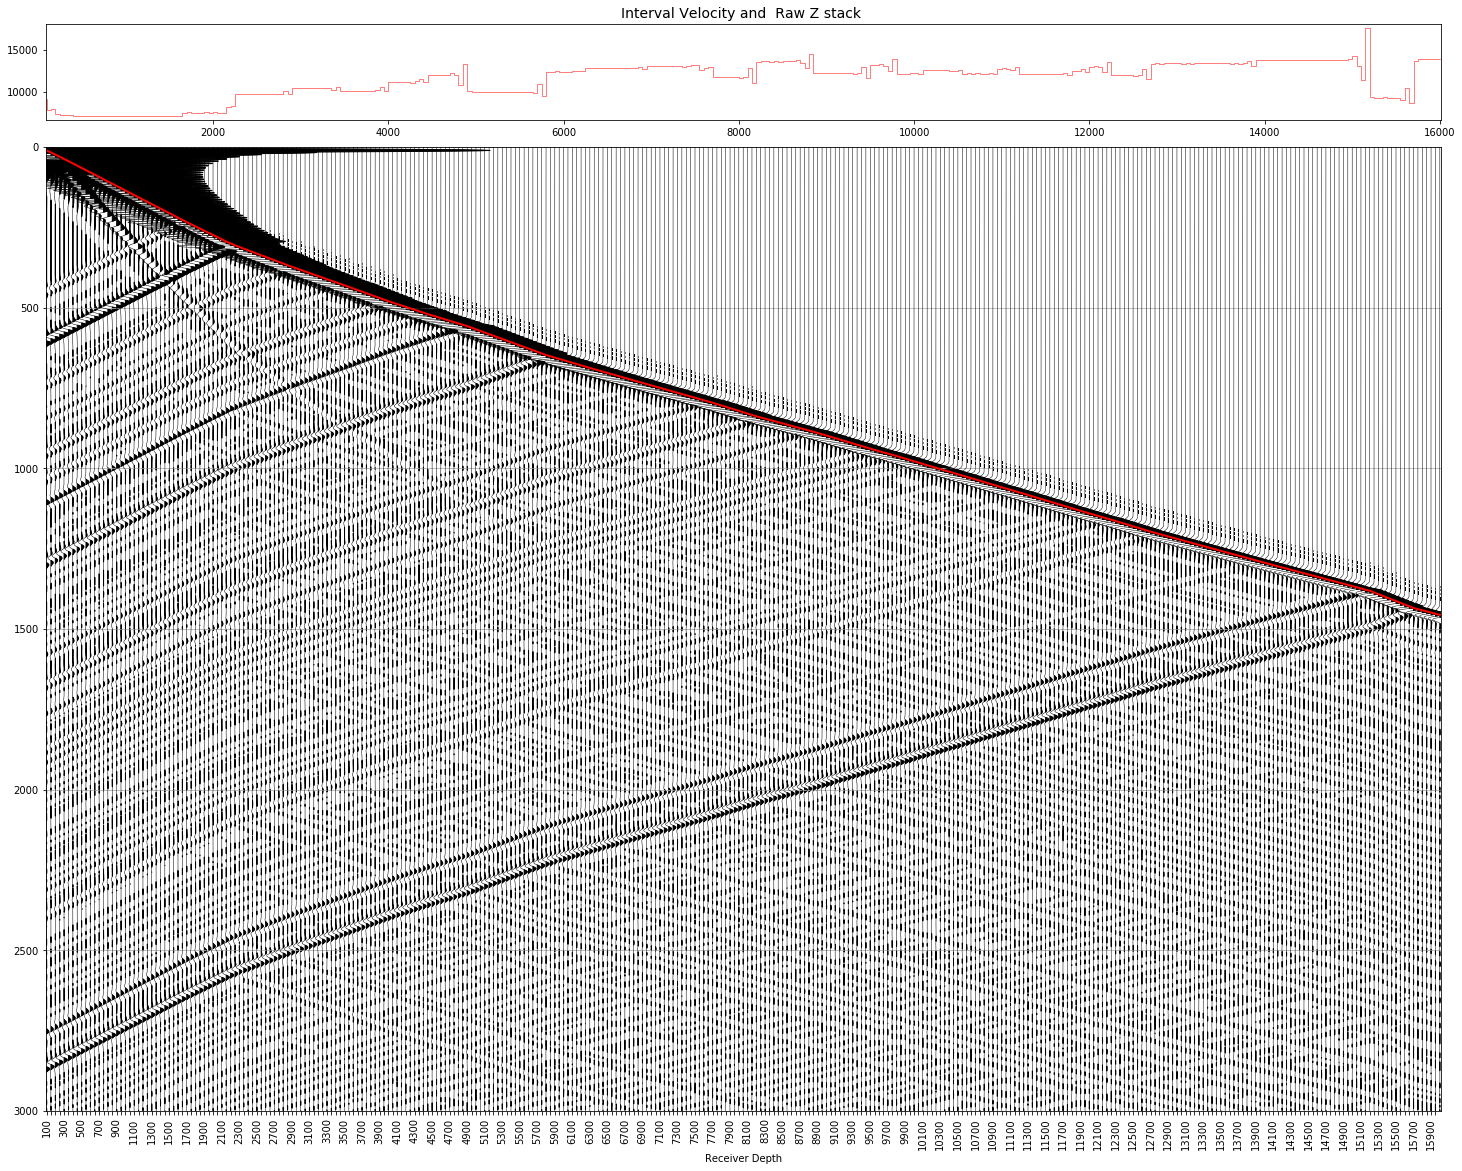


̲N̲o̲r̲m̲a̲l̲i̲z̲a̲t̲i̲o̲n̲ ̲S̲t̲a̲t̲s̲ ̲:
 row_sums shape (319,)

̲W̲i̲g̲g̲l̲e̲ ̲P̲l̲o̲t̲ ̲G̲l̲o̲b̲a̲l̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:
Number of traces in plot : 319  Number of samples per trace : 3050  first rcv : 0
 thead shape : (319, 17)
 datascaled shape [0] 319  datascaled shape [1] 3050
np.min(TVDSRD) - pad 90.0
np.max(TVDSRD) + pad 16010.0
min max intvel : 7082.152974504239 17605.63380281719


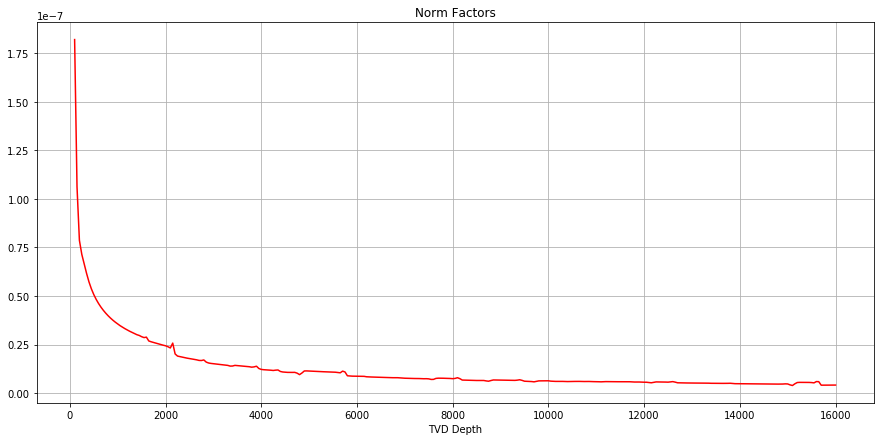

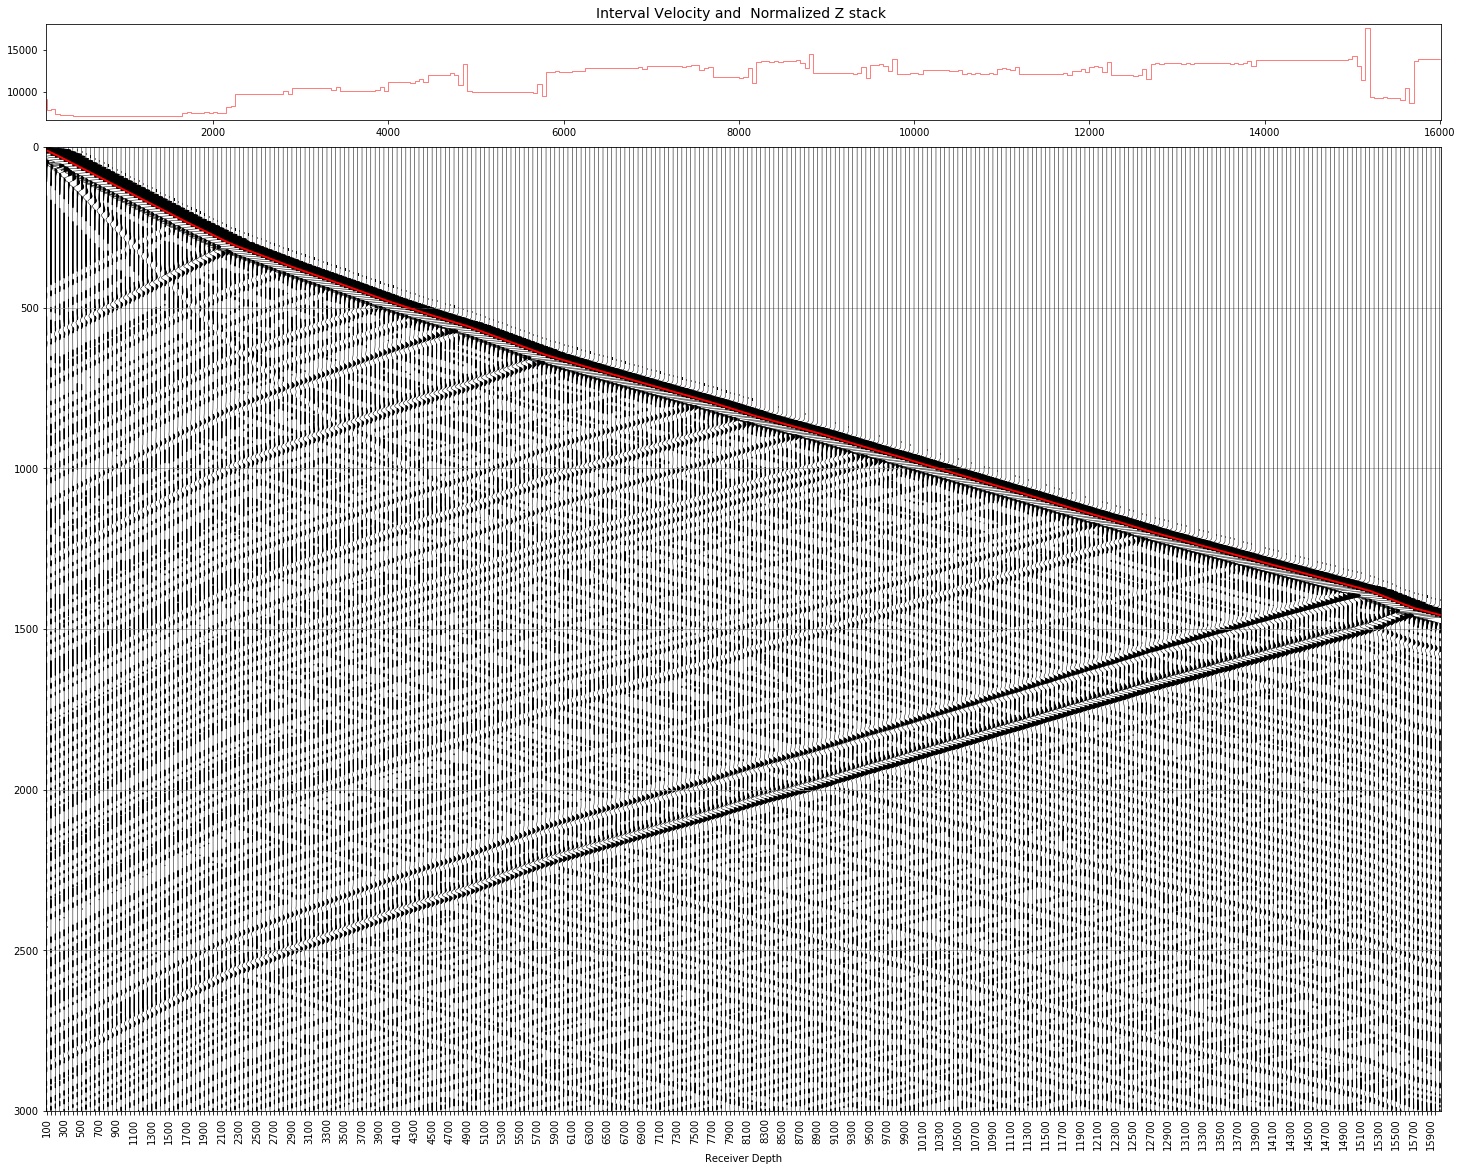


̲S̲h̲i̲f̲t̲i̲n̲g̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
fs : [1000.] 
 atime : 250 
 first arr2 shape : (319, 3050)

̲S̲h̲i̲f̲t̲i̲n̲g̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
fs : [1000.] 
 atime : 250 
 first arr2 shape : (319, 3300)

̲S̲h̲i̲f̲t̲i̲n̲g̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
fs : [1000.] 
 atime : 250 
 first arr2 shape : (319, 3300)
pad twt :  1844 arr shape : (319, 5144)
second arr2 shape : (319, 5144)

̲W̲i̲g̲g̲l̲e̲ ̲P̲l̲o̲t̲ ̲G̲l̲o̲b̲a̲l̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:
Number of traces in plot : 319  Number of samples per trace : 5144  first rcv : 0
 thead shape : (319, 17)
 datascaled shape [0] 319  datascaled shape [1] 5144
np.min(TVDSRD) - pad 90.0
np.max(TVDSRD) + pad 16010.0
min max intvel : 7082.152974504239 17605.63380281719


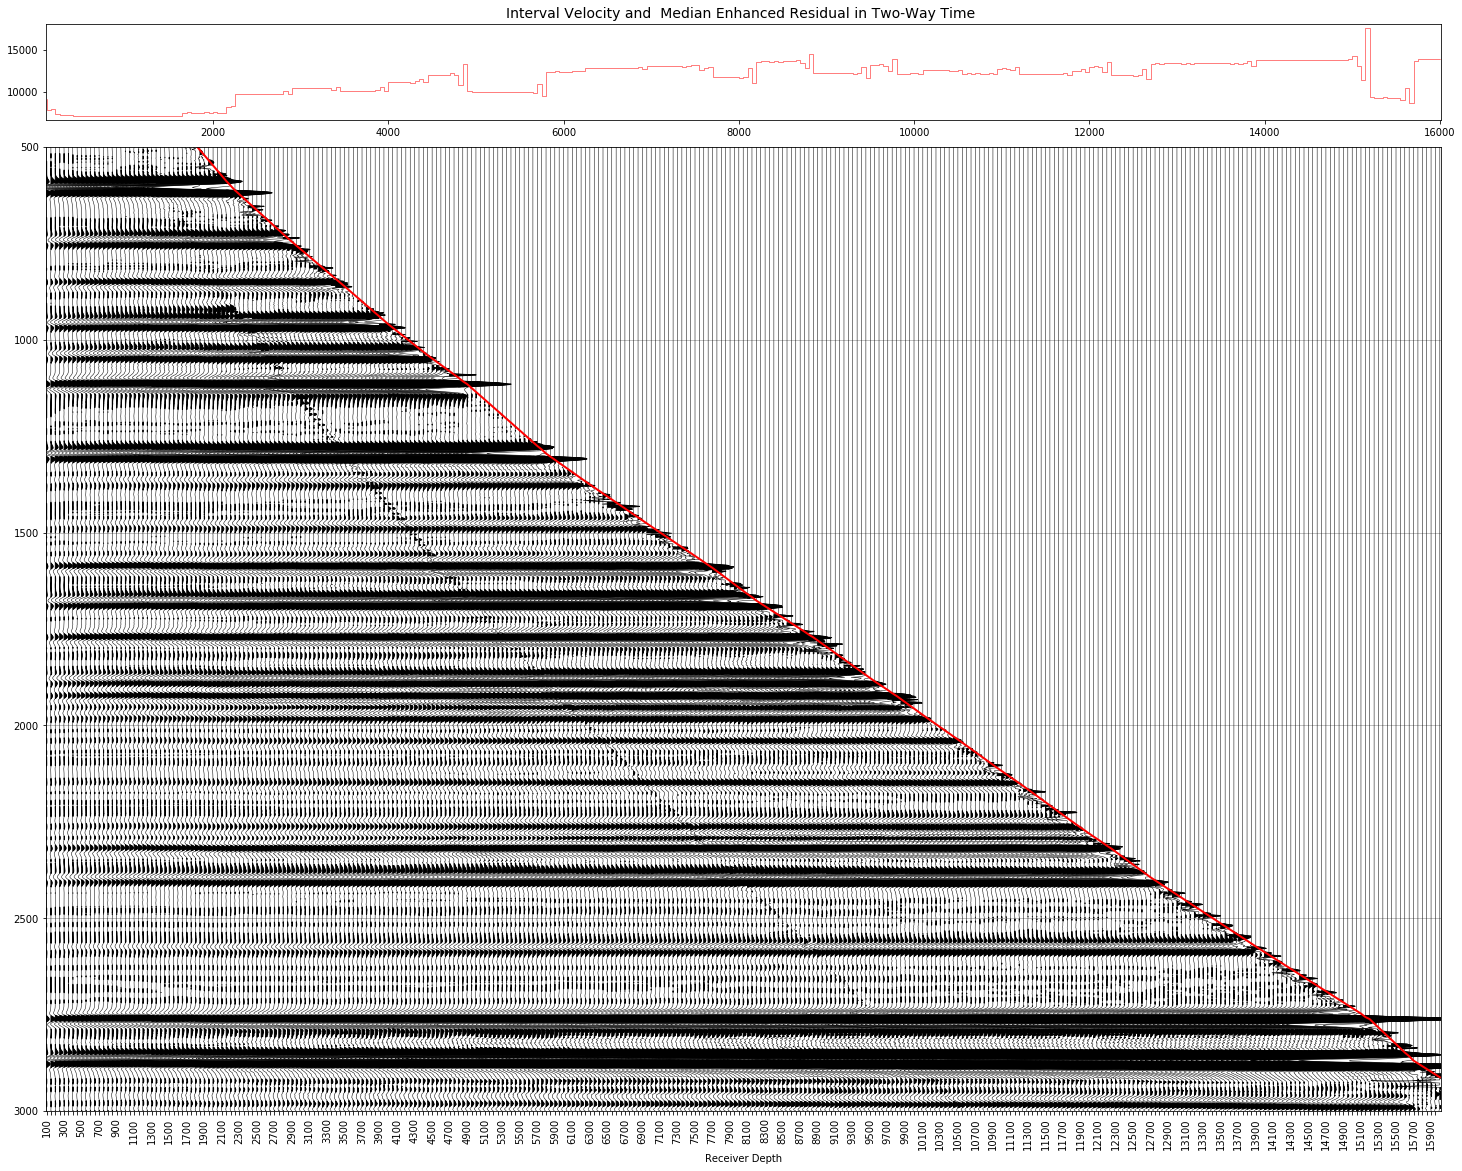


̲F̲o̲u̲r̲ ̲B̲o̲x̲ ̲G̲l̲o̲b̲a̲l̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:
Number of traces in plot : 319  Number of samples per trace :  tindex1 shape :, (3050,)  tindex1 min max : 0.0 3049.0  tindex2 min max : 0.0 3049.0  tindex3 min max : 0.0 3049.0  tindex4 min max : 0.0 3049.0


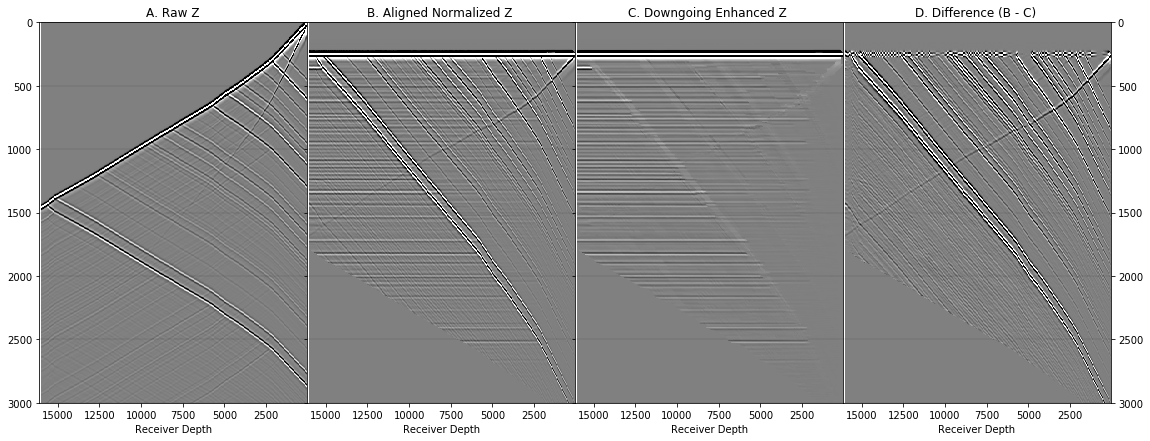


̲F̲o̲u̲r̲ ̲B̲o̲x̲ ̲G̲l̲o̲b̲a̲l̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:
Number of traces in plot : 319  Number of samples per trace :  tindex1 shape :, (3300,)  tindex1 min max : 0.0 3299.0  tindex2 min max : 0.0 3299.0  tindex3 min max : 0.0 3299.0  tindex4 min max : 0.0 3299.0


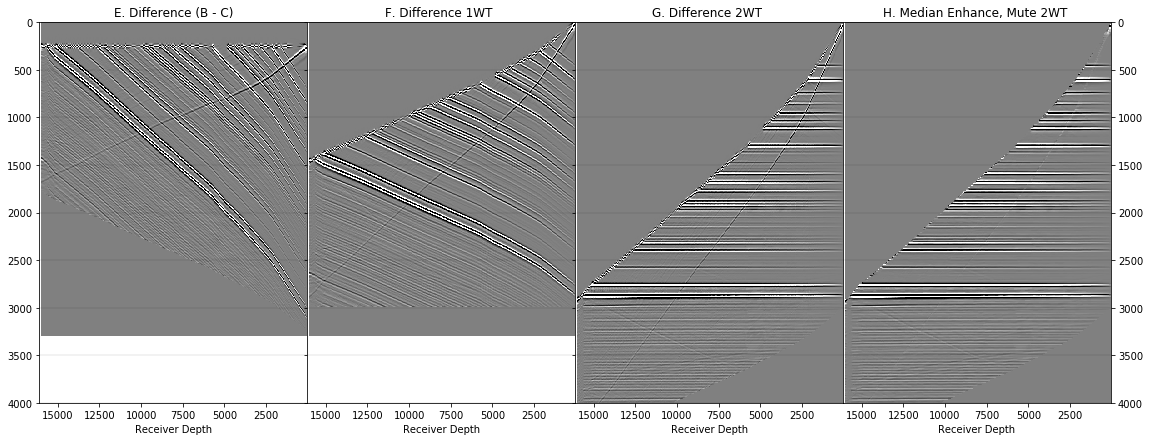


̲W̲i̲g̲g̲l̲e̲ ̲P̲l̲o̲t̲ ̲G̲l̲o̲b̲a̲l̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:
Number of traces in plot : 319  Number of samples per trace : 3050  first rcv : 0
 thead shape : (319, 17)
 datascaled shape [0] 319  datascaled shape [1] 3050
np.min(TVDSRD) - pad 90.0
np.max(TVDSRD) + pad 16010.0
min max intvel : 7082.152974504239 17605.63380281719


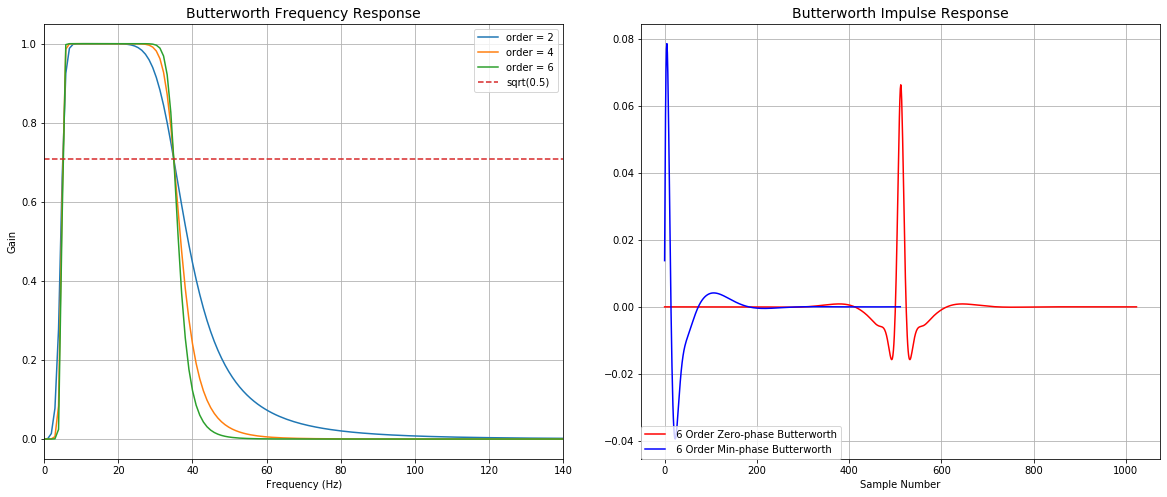

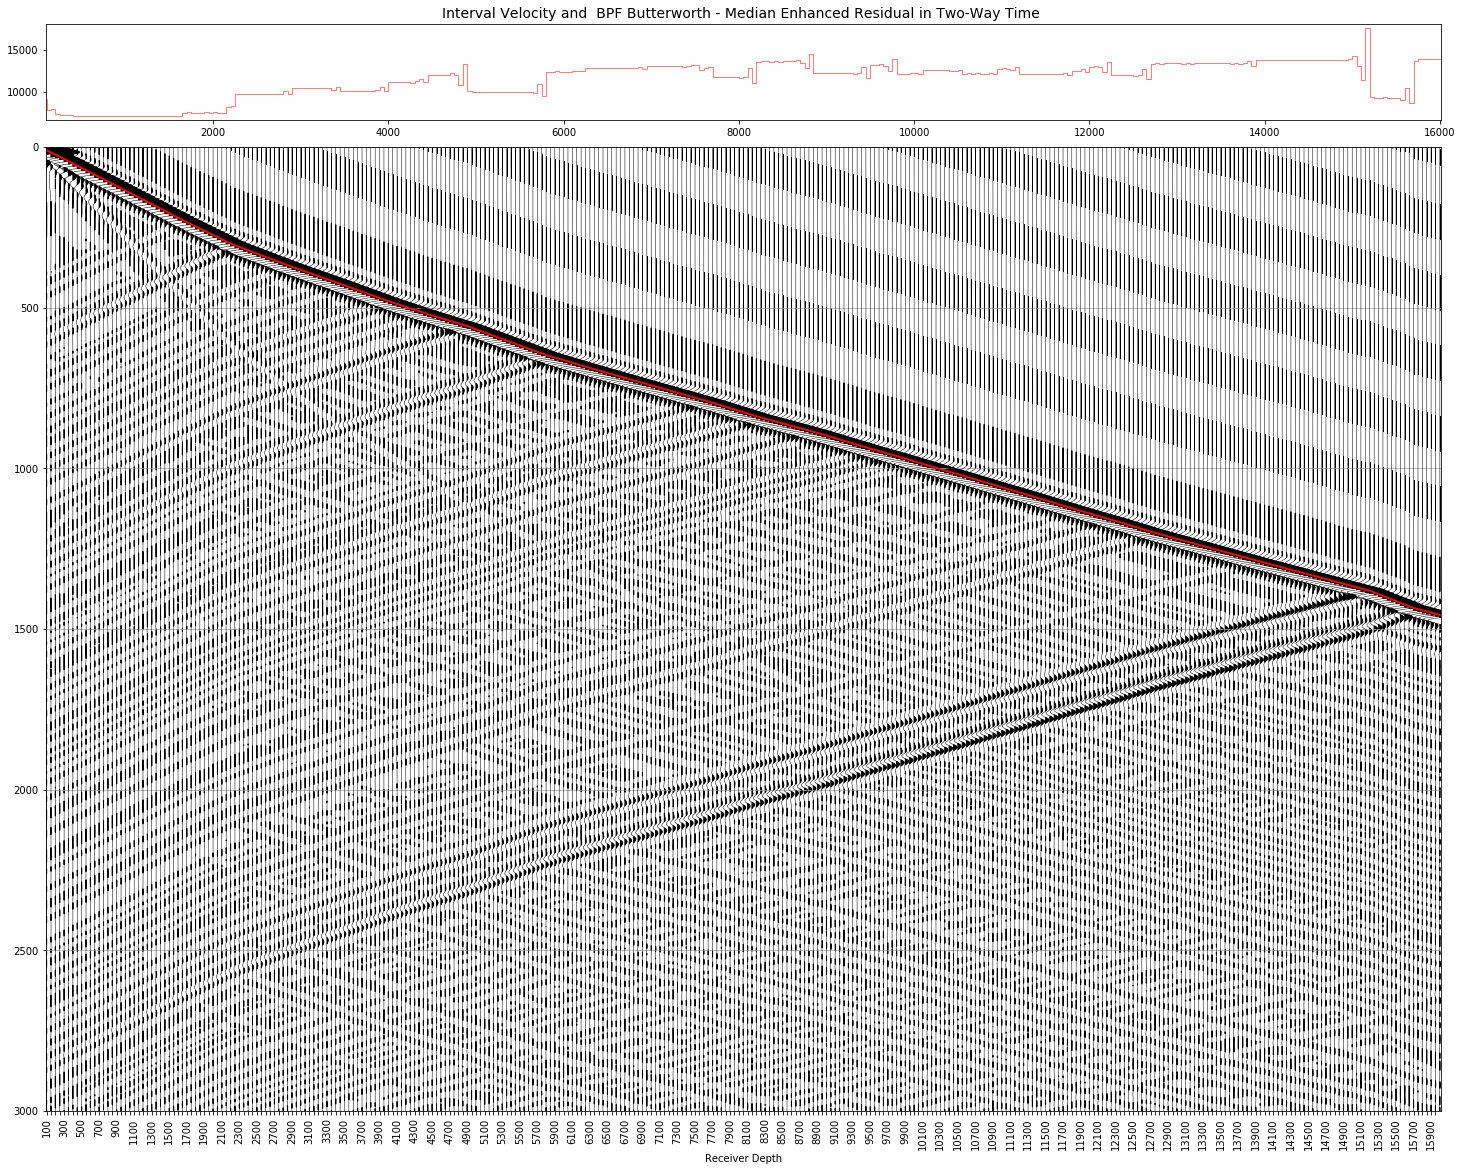


̲F̲r̲A̲n̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
 data single shape : (3050, 1)  TTobs shape : (1,)
fs : [1000.]

̲S̲i̲n̲g̲l̲e̲ ̲T̲r̲a̲c̲e̲ ̲P̲l̲o̲t̲ ̲G̲l̲o̲b̲a̲l̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:
VSP1 shape : (3050, 1)
data1scaled shape : (3050, 1)
data1scaled shape [0] : 3050  Number of samples per trace [1] : 1
 x shape : (3050, 1)  x flat shape : (3050,)


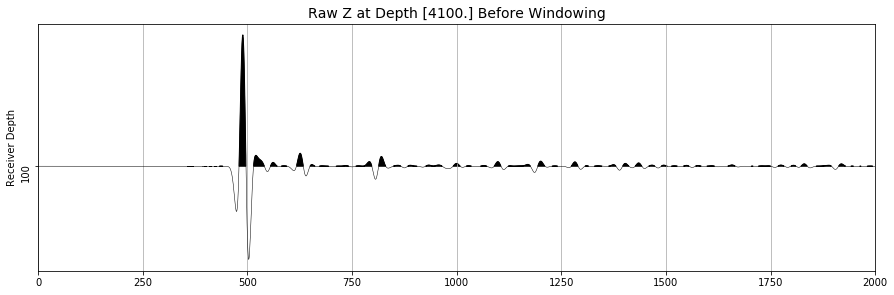

 start : 489  stop : 1513  data single shape : (1513, 1)  N : 1513

̲S̲i̲n̲g̲l̲e̲ ̲T̲r̲a̲c̲e̲ ̲P̲l̲o̲t̲ ̲G̲l̲o̲b̲a̲l̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:
VSP1 shape : (1513, 1)
data1scaled shape : (1513, 1)
data1scaled shape [0] : 1513  Number of samples per trace [1] : 1
 x shape : (1513, 1)  x flat shape : (1513,)


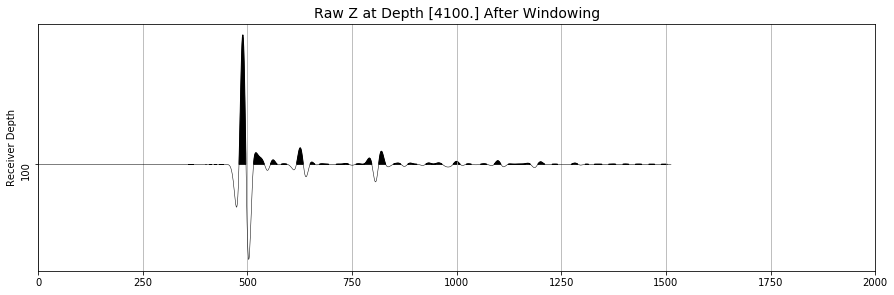

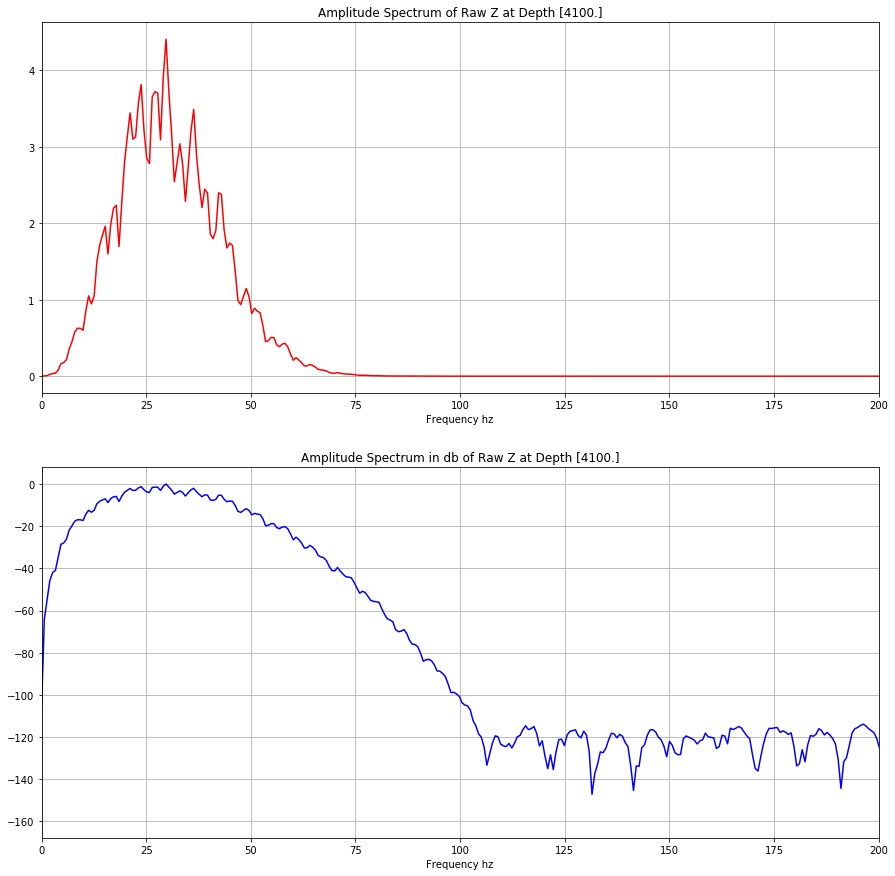


̲F̲r̲A̲n̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
 data single shape : (3050, 1)  TTobs shape : (1,)
fs : [1000.]

̲S̲i̲n̲g̲l̲e̲ ̲T̲r̲a̲c̲e̲ ̲P̲l̲o̲t̲ ̲G̲l̲o̲b̲a̲l̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:
VSP1 shape : (3050, 1)
data1scaled shape : (3050, 1)
data1scaled shape [0] : 3050  Number of samples per trace [1] : 1
 x shape : (3050, 1)  x flat shape : (3050,)


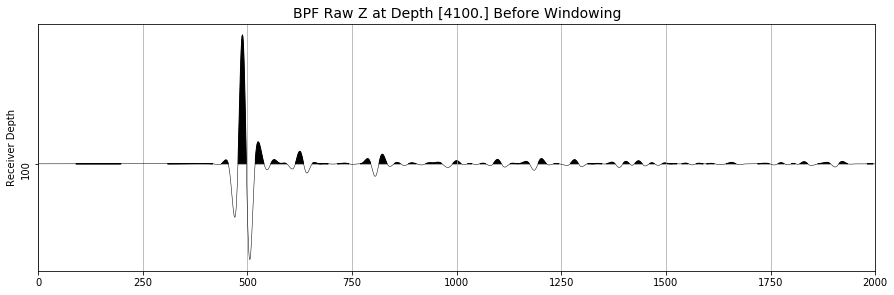

 start : 489  stop : 1513  data single shape : (1513, 1)  N : 1513

̲S̲i̲n̲g̲l̲e̲ ̲T̲r̲a̲c̲e̲ ̲P̲l̲o̲t̲ ̲G̲l̲o̲b̲a̲l̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:
VSP1 shape : (1513, 1)
data1scaled shape : (1513, 1)
data1scaled shape [0] : 1513  Number of samples per trace [1] : 1
 x shape : (1513, 1)  x flat shape : (1513,)


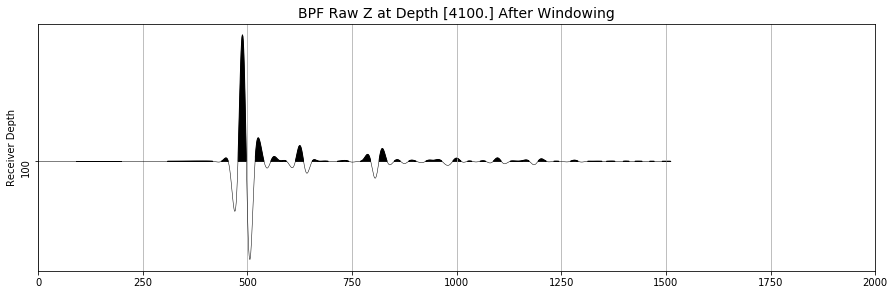

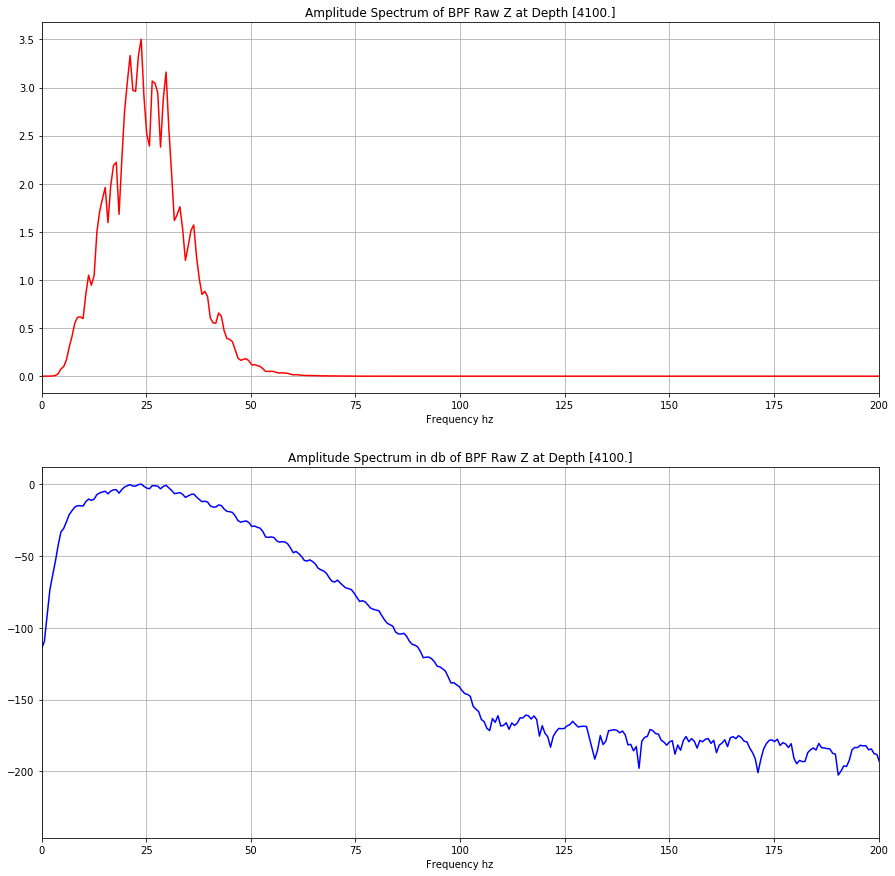


̲W̲r̲i̲t̲e̲ ̲S̲e̲g̲y̲ ̲S̲t̲a̲t̲s̲ ̲:
Data shape [0] : 319 Data shape [1] : 5144
Trace header shape (319, 17)
time header : [[ 1.00000000e+00  1.00000000e+02  1.00000000e+02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+02
   2.18000000e+01  1.00000000e+02  9.00000000e+01 -1.00000000e+01
   0.00000000e+00  1.00000000e+00  0.00000000e+00  1.10000000e+01
   9.17262888e+03]
 [ 2.00000000e+00  1.50000000e+02  1.50000000e+02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+02
   3.46600000e+01  1.50000000e+02  1.40000000e+02 -1.00000000e+01
   0.00000000e+00  1.00000000e+00  0.00000000e+00  1.10000000e+01
   7.77604977e+03]]
MD shape : (319,)  MD dtype : int32
319 Trace(s) in Stream:

Seq. No. in line:    1 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:05.143000Z | 1000.0 Hz, 5144 samples
...
(317 other traces)
...
Seq. No. in line:  319 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:05.143000Z | 1000.0 Hz, 5144 samples

[U

In [27]:
def main ():
    
    #################### get the ZVSP SEGY filename ############################
    
#    filename = ('C:\\Users\\acampbell45\\Documents\\Python_Scripts'
#        '\\Synthetic_data\\data\\zvsp_z_fd_mod6_12p5ft_grid_delayed.sgy')

    filename = ('data\\zvsp_z_fd_mod6_12p5ft_grid_delayed.sgy')
    
    ################### input desired geometry parameters ######################
    
    RepVel= 5000     # replacement velocity
    SRD_ASL = 0    # SRD elevation above sea level
    DF_ASL = 0    # drill floor elevation ASL
    SrcElev = -10   # source elevation ASL

    ###################### run basic segy loading functions #################### 
    
    file_head = 'n'         # print binary and text header to screen
    
    pr_thead = 'n'          # print a table of trace headers
    
    data, numsamp, samprate, fs, theader =  readsegy(filename, file_head, 
                                            DF_ASL, SrcElev, SRD_ASL, pr_thead)
    
    ########### Optional - input desired geometry parameters ###################
    # VSP segy data may not have alll correct headers filled
    # uncomment this section if necessary
    '''
    TDin = '..\data\db_0404_for_time_depth.csv' # time-depth file
    
    Devin = '..\data\dev_MD_TVD.csv' # well deviation
    
    
     samprate = sample rate in microseconds (1000microsec. = 1 ms)
     fs = sample rate in hz (1ms = 1000 hz)
    
    RecvX, RecvY, TVDSRD, TVDSrc, SrcX, SrcY, SrcZSRD, TTobs = importascii(
                                       DF_ASL, SrcElev, SRD_ASL, TDin, Devin)
    '''
    ############ geometry corrections and velocity calculations ################
    
    table = 'n'     # print a time-depth-velocity listing to screen y or n
    
    vel_headers = geovel( theader, RepVel, table)
    
    ###################### trim arrays by receiver  ############################
    
    first_rcv =1
    last_rcv = 320
    
    data_edit, theader_edit = depthlimit(data,vel_headers, first_rcv, last_rcv)
    
    ############ first plot of wiggles and velocities ##########################
    
    Tmax, Tmin = 3000, 0

    hd_spacing = 4 # plot every nth header
    
    tr_spacing = 'z' # Z for traces spread by receiver depth
    
    plot_norm = 'n'         # trace norm = y
    
    plot_polarity = 'n'     # n for normal or tape polarity, r to flip polarity 
    
    Scalar = 100000000000   # check data sample values after read_segy
    
    Title_plot = ' Raw Z stack '
    
    wiggle_plot(theader_edit,data_edit, plot_polarity, Tmax, Tmin, first_rcv, 
                tr_spacing, hd_spacing, fs, plot_norm, Scalar, 
                Title_plot)
    
    ############  apply trace normalization if requested #######################  
    
    Data_norm = 'y'         # normalize data, n for gather norm, y for trace nrm

    DScalar = 1             # usually 1, may be removed in future
    
    normed_edit = normalize(data_edit, Data_norm, theader_edit, DScalar)
    
    Scalar = 1000
     
    Title_plot = ' Normalized Z stack '

    wiggle_plot(theader_edit,normed_edit, plot_polarity, Tmax, Tmin, 
                first_rcv, tr_spacing, hd_spacing, fs, plot_norm, Scalar, 
                Title_plot)
             
    ########### shifting traces ################################################
 
    updown = 'down' # down to align downgoing at aligntime, up to shift to TWT, 
                    # unalign to shift from aligned at aligntime to 1WT
    
    aligntime = 250 # align downgoing at 500ms
    
    alignedVSP, theader_sh = shift(normed_edit, theader_edit, updown, aligntime, 
                                   fs)    
    
    Title_plot = ' Aligned and Normalized Z stack '
    
    ########### median filtering ###############################################
    
    levels = 15
    
    aligndown_scipy = medfilt_across_scipy(alignedVSP, levels) # pad with zeros
    
#    Title_plot = ' Median Enhanced Aligned Downgoing '
    
    residual = diff(alignedVSP, aligndown_scipy)
    
#    Title_plot = 'Residual = Normalized Z stack - Aligned Upgoing '
    
    updown = 'unalign' 
    
    upwave1WT, theader_sh = shift(residual, theader_edit, updown, aligntime,fs)
    
#    Title_plot = ' Residual Shifted To One-Way Time '

    updown = 'up' 
    
    upwave2WT, theader_sh = shift(upwave1WT, theader_edit, updown, aligntime, 
                                  fs)
    
    Tmax, Tmin = 3000, 500
    
#    Title_plot = ' Residual Shifted To Two-Way Time '
    
    levels = 5
    
    medianup2WT = medfilt_across(upwave2WT, levels)
    
    Title_plot = ' Median Enhanced Residual in Two-Way Time ' 

    tframe = 'twt' # owt or twt
    
    mute_medianup2WT = mute(medianup2WT, theader_edit, tframe)
    
    Scalar = 20000
    
    wiggle_plot(theader_sh,mute_medianup2WT, plot_polarity, Tmax, Tmin, 
                first_rcv, tr_spacing, hd_spacing, fs, plot_norm, Scalar, 
               Title_plot)


################# make thumbnail processing plots ##############################    

    ss_title1 = "A. Raw Z"
    
    ss_title2 = "B. Aligned Normalized Z"
    
    ss_title3 = "C. Downgoing Enhanced Z"
    
    ss_title4 = "D. Difference (B - C)"
    
    savePNG = 'y'
    
    png_name = 'pre_decon'
        
    scalar = [150,20,20,8]             # scaling to plot 1,2,3,4 amplitudes
    
    time_range = [0, 3000]
    
    depth_range = [16100, 50]
    
    four_plots(data_edit, alignedVSP, aligndown_scipy, residual, fs, 
               theader_edit, scalar, time_range, depth_range, ss_title1, 
               ss_title2, ss_title3, ss_title4, png_name,savePNG)
    
    ss_title1 = "E. Difference (B - C)"
    
    ss_title2 = "F. Difference 1WT"
    
    ss_title3 = "G. Difference 2WT"
    
    ss_title4 = "H. Median Enhance, Mute 2WT"
    
    png_name = 'pre_decon_enh'
    
    scalar = [10,10,10,10,4]            # scaling to plot 1,2,3,4,5 amplitudes
    
    time_range = [0, 4000]
    
    depth_range = [16100, 50]
    
    four_plots(residual, upwave1WT, upwave2WT, mute_medianup2WT, fs, 
               theader_edit, scalar, time_range, depth_range, ss_title1, 
               ss_title2, ss_title3, ss_title4, png_name,savePNG)
    
    ################### Butterworth filter testing #############################
    
    # Sample rate and desired cutoff frequencies (in Hz).

    lowcut = 5
    highcut = 35
    
    qcplot = 'y'

    order  = 2     # order gets doubled by implementation of filter, be careful
    
    numfsamp = 1024   # for wavelet QC plot, must be even   
   
    buttfilt = butter_bandpass_filter(normed_edit, lowcut, highcut, fs, order, 
                                      numfsamp, qcplot)
    
    Tmax, Tmin = 3000, 0
    
    Scalar = 1000
    
    Title_plot = ' BPF Butterworth - Median Enhanced Residual in Two-Way Time ' 
    
    wiggle_plot(theader_edit,buttfilt, plot_polarity, Tmax, Tmin, first_rcv, 
                tr_spacing, hd_spacing, fs, plot_norm, Scalar, Title_plot)
    
    ########################  FRequency ANalysis    ############################
    
    trace = 80
    
    stime, etime = 0, 2000
    
    spacing = 'z' # Z for traces spread by receiver depth
    
    norm = 'n'
    
    scale = 1000
    
    title_fran = 'Raw Z'
    
    FrAn(normed_edit, stime, etime, theader_edit, trace, fs, spacing, 
         norm, scale, title_fran)
    
    title_fran = 'BPF Raw Z'
    
    FrAn(buttfilt, stime, etime, theader_edit, trace, fs, spacing, 
         norm, scale, title_fran)
            

    #################  output segy ############################################
    '''
    outfilename = ('C:\\Users\\acampbell45\\Documents\\Python_Scripts'
                  '\\Synthetic_data\\data\\residual_2wt.sgy')
    
    outfilename2 = ('C:\\Users\\acampbell45\\Documents\\Python_Scripts'
                  '\\Synthetic_data\\data\\down_flat.sgy')
    '''
    
    outfilename = ('data\\residual_2wt.sgy')
    
    outfilename2 = ('data\\down_flat.sgy')


    
    write_segy(mute_medianup2WT, theader_sh, fs, outfilename)
    
    write_segy(aligndown_scipy, theader_edit, fs, outfilename2)
    

main()